# 04. PyTorch 自定义数据集

在上一个笔记本中，[笔记本 03](./03_pytorch_computer_vision.ipynb)，我们介绍了如何在 PyTorch 中使用内置数据集（如 FashionMNIST）构建计算机视觉模型。

我们采取的步骤对于许多不同的机器学习问题都是相似的。

找到一个数据集，将数据集转换为数字，构建一个模型（或找到现有的模型），从这些数字中找到可以用于预测的模式。

PyTorch 提供了许多内置数据集，用于各种机器学习基准测试，但你通常会希望使用自己的 **自定义数据集**。

## 什么是自定义数据集？

**自定义数据集**是与您正在处理的特定问题相关的数据集合。

本质上，**自定义数据集**几乎可以包含任何内容。

例如，如果我们要构建一个食品图像分类应用程序，比如 [Nutrify](https://nutrify.app)，我们的自定义数据集可能是食品的图像。

或者，如果我们想构建一个模型来分类网站上的文本评论是积极的还是消极的，我们的自定义数据集可能是现有客户评论及其评分的示例。

又或者，如果我们在构建一个声音分类应用程序，我们的自定义数据集可能是声音样本及其标签。

如果我们要构建一个为顾客推荐商品的推荐系统，我们的自定义数据集可能是其他人购买的商品示例。

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png" alt="不同的 PyTorch 领域库可以用于特定的 PyTorch 问题" width=1000/>

*PyTorch 包含许多现有函数，用于加载各种自定义数据集，涵盖了 [`TorchVision`](https://pytorch.org/vision/stable/index.html)、[`TorchText`](https://pytorch.org/text/stable/index.html)、[`TorchAudio`](https://pytorch.org/audio/stable/index.html) 和 [`TorchRec`](https://pytorch.org/torchrec/) 等领域库。*

但有时，这些现有函数可能不足以满足需求。

在这种情况下，我们可以始终通过继承 `torch.utils.data.Dataset` 类，并根据需要进行自定义。

## 我们将要覆盖的内容

我们将应用在 [笔记本 01](./01_pytorch_workflow.ipynb) 和 [笔记本 02](./02_pytorch_classification.ipynb) 中介绍的 PyTorch 工作流来解决一个计算机视觉问题。

但与使用 PyTorch 内置数据集不同，我们将使用我们自己的数据集——包括比萨、牛排和寿司的图像。

目标是加载这些图像，然后构建一个模型来训练和预测这些图像。

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="构建一个管道来加载食品图像，然后构建一个 PyTorch 模型来分类这些食品图像" width=800 />

*我们将要构建的内容。我们将使用 `torchvision.datasets` 以及我们自己的自定义 `Dataset` 类来加载食品图像，然后我们将构建一个 PyTorch 计算机视觉模型，希望能够对这些图像进行分类。*

具体来说，我们将覆盖以下内容：

| **主题** | **内容** |
| ----- | ----- |
| **0. 导入 PyTorch 并设置设备无关代码** | 让我们加载 PyTorch，然后按照最佳实践设置我们的代码，使其与设备无关。 |
| **1. 获取数据** | 我们将使用自己的 **自定义数据集**，包括比萨、牛排和寿司图像。 |
| **2. 了解数据（数据准备）** | 在任何新的机器学习问题的开始，理解你正在处理的数据至关重要。在这里，我们将采取一些步骤来弄清楚我们拥有的数据。 |
| **3. 转换数据** | 通常，你得到的数据不会 100% 准备好使用机器学习模型，在这里我们将查看一些步骤，看看如何*转换*我们的图像，以便它们可以准备好用于模型。 |
| **4. 使用 `ImageFolder` 加载数据（选项 1）** | PyTorch 为常见类型的数据提供了许多内置的数据加载函数。如果我们的图像是标准的图像分类格式，`ImageFolder` 会很有帮助。 |
| **5. 使用自定义 `Dataset` 加载图像数据** | 如果 PyTorch 没有内置函数来加载数据怎么办？在这种情况下，我们可以构建一个自定义的 `torch.utils.data.Dataset` 子类。 |
| **6. 其他形式的转换（数据增强）** | 数据增强是扩展训练数据多样性的常见技术。在这里，我们将探索一些 `torchvision` 内置的数据增强函数。 |
| **7. 模型 0：没有数据增强的 TinyVGG** | 到这一步，我们的数据应该已经准备好了，接下来我们将构建一个能够拟合这些数据的模型。我们还将创建一些训练和测试函数，用于训练和评估我们的模型。 |
| **8. 探索损失曲线** | 损失曲线是查看模型如何随时间训练/改进的好方法。它们也是判断模型是否**欠拟合**或**过拟合**的好方式。 |
| **9. 模型 1：带数据增强的 TinyVGG** | 到目前为止，我们尝试了一个*没有*数据增强的模型，接下来我们试试一个*有*数据增强的模型。 |
| **10. 比较模型结果** | 让我们比较不同模型的损失曲线，看看哪一个表现更好，并讨论一些改进性能的选项。 |
| **11. 对自定义图像进行预测** | 我们的模型已经在比萨、牛排和寿司的图像数据集上进行了训练。在本节中，我们将介绍如何使用训练好的模型对数据集*以外*的图像进行预测。 |

## 0. 导入 PyTorch 并设置设备无关代码

In [1]:
import torch
from torch import nn

# 注意：此笔记本需要 torch >= 1.10.0
torch.__version__

'2.5.1'

现在让我们遵循最佳实践，设置设备无关的代码。

> **注意：** 如果你正在使用 Google Colab，并且还没有开启 GPU，现在是时候通过 `Runtime -> Change runtime type -> Hardware accelerator -> GPU` 来开启 GPU 了。如果你这样做了，运行时可能会重置，你需要通过 `Runtime -> Run before` 重新运行上述所有单元格。

In [2]:
# 设置设备无关代码
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. 获取数据

首先，我们需要一些数据。

就像任何优秀的烹饪节目一样，有些数据已经为我们准备好了。

我们将从小处开始。

因为我们目前还不打算训练最大型的模型，也不使用最大型的数据集。

机器学习是一个迭代的过程，从小做起，确保某些东西能运行，然后在必要时进行扩展。

我们将要使用的数据是 [Food101 数据集](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) 的一个子集。

Food101 是一个流行的计算机视觉基准数据集，因为它包含了 101 种不同食物的 1000 张图片，共计 101,000 张图片（75,750 张训练图片和 25,250 张测试图片）。

你能想到 101 种不同的食物吗？

你能想到一个程序来分类这 101 种食物吗？

我可以。

一个机器学习模型！

具体来说，一个 PyTorch 计算机视觉模型，正如我们在 [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/) 中介绍的那样。

不过，我们不从 101 种食物类别开始，而是从 3 种：比萨、牛排和寿司。

而且，不从每个类别 1000 张图片开始，而是从随机选择的 10% 开始（从小做起，必要时再增加）。

如果你想了解这些数据来自哪里，可以参考以下资源：
* 原始 [Food101 数据集和论文网站](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)。
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - 我为这个 notebook 下载的版本。
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - 用于格式化 Food101 数据集以供本 notebook 使用的 notebook。
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - 来自 Food101 的比萨、牛排和寿司图片的压缩包，使用上面的 notebook 创建。

让我们写些代码，从 GitHub 下载格式化后的数据。

> **注意：** 我们将要使用的数据集已经为我们的用途预先格式化好了。然而，在实际应用中，你通常需要自己格式化数据集，以适应你正在解决的问题。这是机器学习领域中的常规做法。

In [3]:
import requests
import zipfile
from pathlib import Path

# 设置数据文件夹路径
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# 如果图像文件夹不存在，则下载并准备数据...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # 下载比萨、牛排、寿司数据
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # 解压比萨、牛排、寿司数据
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


## 2. 与数据合二为一（数据准备）

数据集下载完毕！

现在是时候与数据合二为一了。

这是构建模型之前的另一个重要步骤。

正如Abraham Lossfunction所说...

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-abraham-lossfunction.png" alt="mrdbourke的推文：如果我有8小时来构建机器学习模型，我会花6小时准备数据集" width=800/>

*数据准备至关重要。在构建模型之前，要与数据合二为一。问问自己：我在这里想做什么？ 来源: [@mrdbourke Twitter](https://twitter.com/mrdbourke)。*

那么，什么是检查数据并与其合一呢？

在开始一个项目或构建任何类型的模型之前，了解你正在使用的数据非常重要。

在我们的例子中，我们有比萨、牛排和寿司的图像，这些图像符合标准的图像分类格式。

图像分类格式包含多个类别的图像，这些类别的图像存放在分别以类别名命名的文件夹中。

例如，所有的 `pizza` 图像都存放在 `pizza/` 文件夹中。

这种格式在许多不同的图像分类基准测试中很常见，包括 [ImageNet](https://www.image-net.org/)（最流行的计算机视觉基准数据集之一）。

你可以看到以下存储格式的示例，图像编号是随意的。

```
pizza_steak_sushi/ <- 总数据集文件夹
    train/ <- 训练图像
        pizza/ <- 类别名作为文件夹名称
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- 测试图像
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```

我们的目标是**将这个数据存储结构转换成一个可以在PyTorch中使用的数据集**。

> **注意：** 你处理的数据结构会根据所解决的问题有所不同。但前提依然不变：与数据合二为一，然后找到最佳方式将其转化为一个与PyTorch兼容的数据集。

我们可以通过编写一个小的辅助函数，遍历每个子目录并计算文件的数量，从而检查数据目录中的内容。

为此，我们将使用Python内置的 [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk) 方法。

In [4]:
import os
def walk_through_dir(dir_path):
  """
  遍历给定的目录路径，并返回其内容。
  参数：
    dir_path (str 或 pathlib.Path): 目标目录
  
  返回：
    打印输出以下内容：
      dir_path 中的子目录数量
      每个子目录中的图像（文件）数量
      每个子目录的名称
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


看起来我们每个训练类大约有 75 张图像，每个测试类大约有 25 张图像。

这应该足够让我们开始了。

记住，这些图像是原始 Food101 数据集的子集。

你可以查看它们是如何创建的，详见 [数据创建笔记本](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb)。

既然我们已经完成了这一步，接下来让我们设置训练和测试的路径。

In [6]:
# 设置训练和测试路径
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 可视化一张图像

好的，我们已经了解了目录结构的格式。

现在，在数据探索的精神下，是时候 *可视化、可视化、再可视化* 了！

让我们编写一些代码来：
1. 使用 [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) 获取所有图像路径，找到所有以 `.jpg` 结尾的文件。
2. 使用 Python 的 [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice) 随机选择一个图像路径。
3. 使用 [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent) 获取图像的类别名称。
4. 由于我们正在处理图像，所以使用 [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) 打开随机选择的图像路径（PIL 代表 Python 图像库）。
5. 然后，我们将显示该图像并打印一些元数据。

Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


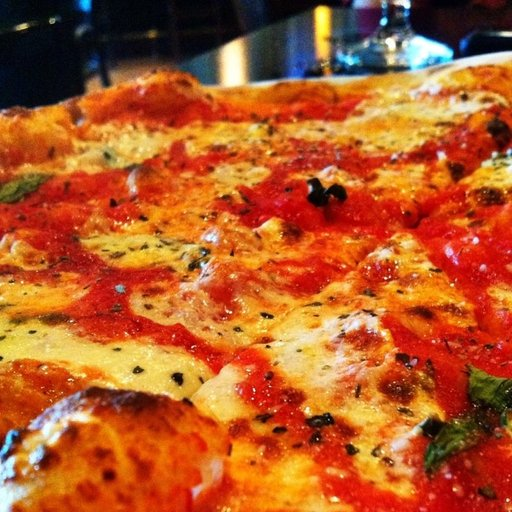

In [7]:
import random
from PIL import Image

# 设置随机种子
random.seed(42)  # <- 尝试更改这个值看看会发生什么

# 1. 获取所有图像路径 (* 表示"任意组合")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. 获取随机图像路径
random_image_path = random.choice(image_path_list)

# 3. 从路径名称中获取图像类别（图像类别是存储图像的目录名称）
image_class = random_image_path.parent.stem

# 4. 打开图像
img = Image.open(random_image_path)

# 5. 打印元数据
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

我们可以使用 [`matplotlib.pyplot.imshow()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html) 做同样的事情，不过我们需要先将图像转换为 NumPy 数组。

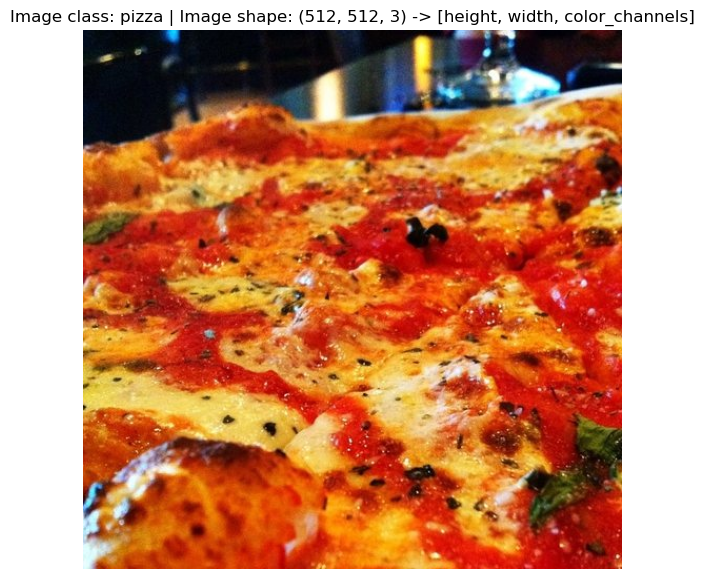

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 将图像转换为数组
img_as_array = np.asarray(img)

# 使用matplotlib绘制图像
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. 数据转换

那么，如果我们想要将图像数据加载到 PyTorch 中，怎么办呢？

在我们可以使用 PyTorch 处理图像数据之前，我们需要：

1. 将图像转换为张量（图像的数值表示）。
2. 将数据转换为 `torch.utils.data.Dataset`，并随后转换为 `torch.utils.data.DataLoader`，我们将简化称之为 `Dataset` 和 `DataLoader`。

PyTorch 提供了几种不同的预构建数据集和数据加载器，具体取决于你正在处理的问题。

| **问题领域** | **预构建数据集和功能** |
| ----- | ----- |
| **计算机视觉** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **音频** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **文本** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **推荐系统** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

由于我们正在处理的是计算机视觉问题，我们将使用 `torchvision.datasets` 来加载数据，并使用 [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) 来准备我们的数据。

接下来，让我们导入一些基础库。

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 使用 `torchvision.transforms` 转换数据

我们有了图像文件夹，但在将它们用于 PyTorch 之前，我们需要将它们转换为张量。

我们可以使用 `torchvision.transforms` 模块来实现这一点。

`torchvision.transforms` 包含了许多预构建的方法，用于格式化图像、将图像转换为张量，甚至可以对图像进行处理以进行 **数据增强**（通过改变数据使得模型更难以学习，稍后我们将详细介绍）。

为了熟悉 `torchvision.transforms`，我们将编写一系列转换步骤，包括：

1. 使用 [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) 调整图像大小（将约 512x512 的图像调整为 64x64，与 [CNN Explainer 网站](https://poloclub.github.io/cnn-explainer/) 上的图像相同）。
2. 使用 [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) 随机水平翻转图像（这可以视为一种数据增强，因为它将人工改变我们的图像数据）。
3. 使用 [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor) 将图像从 PIL 图像转换为 PyTorch 张量。

我们可以通过 [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) 将这些步骤组合起来。

In [10]:
# 编写图像转换函数
data_transform = transforms.Compose([
    # 将图像调整为 64x64
    transforms.Resize(size=(64, 64)),
    # 随机水平翻转图像
    transforms.RandomHorizontalFlip(p=0.5), # p = 翻转概率，0.5 = 50% 的概率
    # 将图像转换为 torch.Tensor
    transforms.ToTensor() # 这也将所有像素值从 0 到 255 转换为 0.0 到 1.0 之间的浮动值
])

现在我们已经有了一组转换操作，让我们写一个函数来在不同的图像上尝试这些转换。

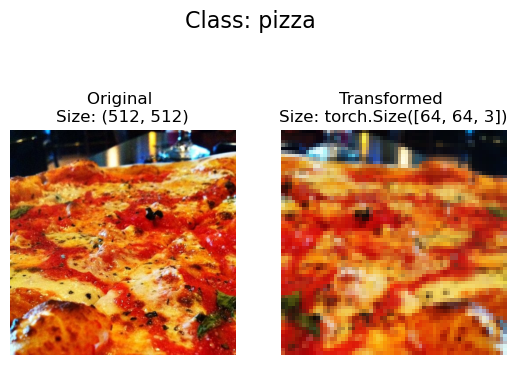

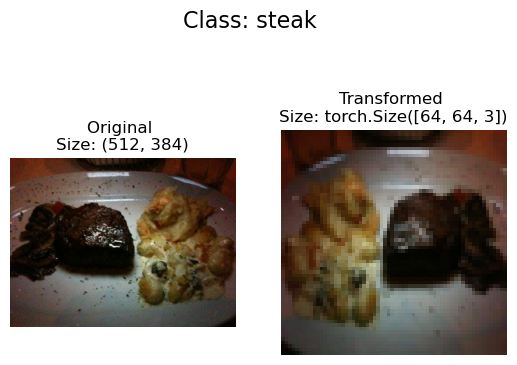

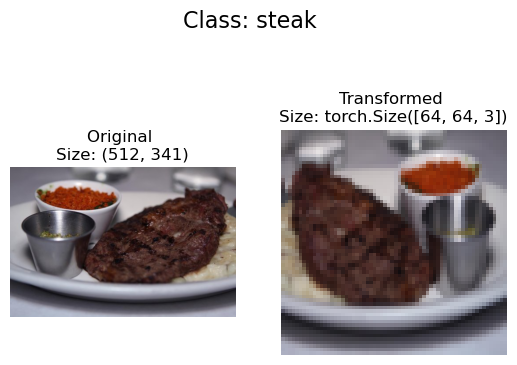

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """绘制一系列随机图像。

    从 image_paths 中打开 n 张图像路径，使用 transform 对它们进行转换，并将它们并排显示。

    参数：
        image_paths (list): 目标图像路径的列表。
        transform (PyTorch 转换): 要应用于图像的转换操作。
        n (int, optional): 要绘制的图像数量，默认为 3。
        seed (int, optional): 随机种子，用于随机生成器，默认为 42。
    """
    random.seed(seed)  # 设置随机种子
    random_image_paths = random.sample(image_paths, k=n)  # 从 image_paths 中随机选择 n 张图像
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)  # 创建两个子图
            ax[0].imshow(f)  # 显示原始图像
            ax[0].set_title(f"Original \nSize: {f.size}")  # 设置原始图像的标题
            ax[0].axis("off")  # 关闭坐标轴

            # 转换并显示图像
            # 注意：permute() 将改变图像的形状以适应 matplotlib
            # (PyTorch 默认是 [C, H, W]，但 Matplotlib 是 [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)  # 进行转换并调整顺序
            ax[1].imshow(transformed_image)  # 显示转换后的图像
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")  # 设置转换图像的标题
            ax[1].axis("off")  # 关闭坐标轴

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)  # 设置整个图像的标题

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)  # 调用函数显示 3 张转换后的图像

我们现在已经有了一个使用 `torchvision.transforms` 将图像转换为张量的方法。

我们还可以根据需要调整图像的大小和方向（有些模型更喜欢不同大小和形状的图像）。

通常来说，图像的大小越大，模型能恢复的信息就越多。

例如，大小为 `[256, 256, 3]` 的图像将比大小为 `[64, 64, 3]` 的图像拥有更多的像素，具体来说，大约是前者的 16 倍（`(256*256*3)/(64*64*3)=16`）。

然而，更多的像素也意味着更多的计算。

> **练习：** 尝试注释掉 `data_transform` 中的一个转换操作，然后再次运行绘图函数 `plot_transformed_images()`，会发生什么？

## 4. 选项 1：使用 [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder) 加载图像数据

好了，现在是时候将我们的图像数据转换为可以在 PyTorch 中使用的 `Dataset` 了。

由于我们的数据采用标准的图像分类格式，我们可以使用 [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder) 类。

我们可以将目标图像目录的文件路径以及希望对图像执行的转换操作传递给它。

接下来，让我们在我们的数据文件夹 `train_dir` 和 `test_dir` 上测试一下，传入 `transform=data_transform` 将图像转换为张量。

In [12]:
# 使用 ImageFolder 创建数据集
from torchvision import datasets

train_data = datasets.ImageFolder(
    root=train_dir,  # 图像的目标文件夹
    transform=data_transform,  # 对数据（图像）执行的转换操作
    target_transform=None  # 对标签执行的转换操作（如果需要）
)

test_data = datasets.ImageFolder(
    root=test_dir, 
    transform=data_transform
)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )



看起来 PyTorch 已经注册了我们的 `Dataset`。

让我们通过查看 `classes` 和 `class_to_idx` 属性，以及检查训练集和测试集的长度来进一步检查它们。

In [13]:
# 获取类名列表
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# 也可以将类名作为字典获取
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# 检查数据集的长度
len(train_data), len(test_data)

(225, 75)

看起来我们可以将这些作为参考，稍后使用。

那么我们的图像和标签怎么样？

它们看起来如何？

我们可以在我们的 `train_data` 和 `test_data` 数据集 (`Dataset`) 上进行索引，以查找样本及其目标标签。

In [16]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

我们的图像现在是一个张量形式（形状为 `[3, 64, 64]`），标签是与特定类别相关的整数（由 `class_to_idx` 属性引用）。

我们要不要用 `matplotlib` 绘制一张单独的图像张量？

我们首先需要进行维度变换（重新排列维度的顺序），使其兼容。

目前我们的图像维度格式是 `CHW`（颜色通道，高度，宽度），但 `matplotlib` 更喜欢 `HWC`（高度，宽度，颜色通道）。

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

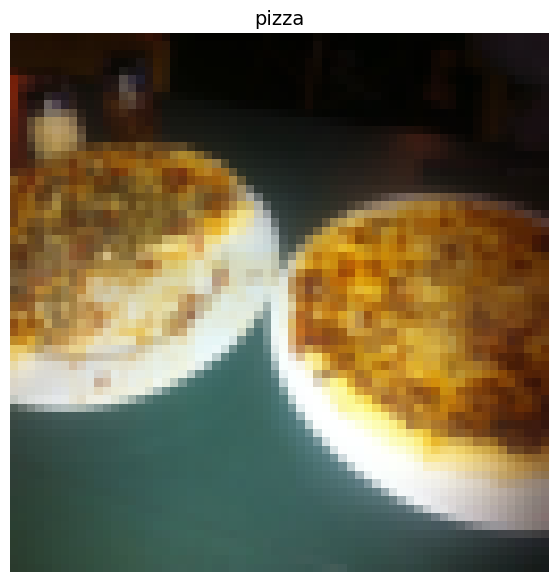

In [17]:
# 重新排列维度的顺序
img_permute = img.permute(1, 2, 0)

# 打印不同形状（变换前和变换后）
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# 绘制图像
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14)

注意到图像现在变得更加像素化（质量降低）。

这是因为它被从 `512x512` 尺寸调整为 `64x64` 像素。

这里的直觉是，如果你觉得图像变得更难识别，那么模型也可能会更难理解图像中的内容。

### 4.1 将加载的图像转化为 `DataLoader`

我们已经将图像加载为 PyTorch 的 `Dataset`，现在让我们将它们转化为 `DataLoader`。

我们将使用 [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) 来实现这一点。

将 `Dataset` 转换为 `DataLoader` 使其可迭代，这样模型就可以通过数据加载器学习样本与目标（特征与标签）之间的关系。

为了简化，我们将使用 `batch_size=1` 和 `num_workers=1`。

什么是 `num_workers`？

好问题。

它定义了为加载数据而创建的子进程数。

可以这样理解，`num_workers` 设置的值越高，PyTorch 就会使用越多的计算资源来加载数据。

就个人而言，我通常通过 Python 的 [`os.cpu_count()`](https://docs.python.org/3/library/os.html#os.cpu_count) 将其设置为我机器上 CPU 的总数量。

这样可以确保 `DataLoader` 利用尽可能多的核心来加载数据。

> **注意：** 你可以通过 [PyTorch 文档](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) 熟悉更多 `torch.utils.data.DataLoader` 的参数。

In [18]:
# 将训练集和测试集的 Datasets 转换为 DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1,  # 每个批次有多少个样本？
                              num_workers=1,  # 用多少个子进程来加载数据？（值越高使用的计算资源越多）
                              shuffle=True)  # 是否打乱数据？

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False)  # 通常测试数据不需要打乱

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16b7f90d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1788be990>)

现在我们的数据是可迭代的了。

让我们试试并检查一下形状。

In [19]:
img, label = next(iter(train_dataloader))

# 批次大小现在是 1，试着改变上面 `batch_size` 参数的值，看看会发生什么。
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


我们现在可以使用这些 `DataLoader` 来进行训练和测试循环，以训练一个模型。

但是在此之前，让我们看看另一种加载图像（或几乎任何其他类型数据）的方法。

## 5. 选项 2：使用自定义 `Dataset` 加载图像数据

如果像 [`torchvision.datasets.ImageFolder()`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) 这样的预构建 `Dataset` 创建器不存在怎么办？

或者没有适用于你特定问题的 `Dataset` 创建器？

那么，你可以自己构建一个。

但是等等，创建自己自定义的加载 `Dataset` 的方式有什么优缺点呢？

| 创建自定义 `Dataset` 的优点 | 创建自定义 `Dataset` 的缺点 |
| ----- | ----- |
| 可以从几乎任何东西创建 `Dataset`。 | 虽然你 *可以* 从几乎任何东西创建 `Dataset`，但这并不意味着它能正常工作。 |
| 不受限于 PyTorch 预构建的 `Dataset` 函数。 | 使用自定义 `Dataset` 通常需要编写更多代码，这可能会导致错误或性能问题。 |

为了演示这一点，让我们通过继承 `torch.utils.data.Dataset`（PyTorch 中所有 `Dataset` 的基类）来复制 `torchvision.datasets.ImageFolder()`。

我们将从导入所需的模块开始：
* Python 的 `os` 用于处理目录（我们的数据存储在目录中）。
* Python 的 `pathlib` 用于处理文件路径（每张图像都有一个唯一的文件路径）。
* `torch` 用于 PyTorch 的所有操作。
* PIL 的 `Image` 类用于加载图像。
* `torch.utils.data.Dataset` 用于继承并创建我们自己的自定义 `Dataset`。
* `torchvision.transforms` 用于将我们的图像转换为张量。
* Python `typing` 模块中的各种类型，用于为我们的代码添加类型提示。

> **注意：** 你可以根据自己的数据集自定义以下步骤。基本思路是：编写代码以你希望的格式加载数据。

In [20]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

还记得我们之前使用的 `torchvision.datasets.ImageFolder()` 实例是如何让我们使用 `classes` 和 `class_to_idx` 属性的吗？

In [21]:
# torchvision.datasets.ImageFolder() 的实例
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 创建一个辅助函数来获取类名

让我们编写一个辅助函数，能够根据目录路径创建类名的列表以及类名和它们的索引的字典。

为此，我们将：
1. 使用 `os.scandir()` 获取类名，通过遍历目标目录（理想情况下，目录应该是标准的图像分类格式）。
2. 如果没有找到类名，抛出错误（如果发生这种情况，目录结构可能存在问题）。
3. 将类名转换为一个数字标签的字典，每个类对应一个数字标签。

在编写完整的函数之前，让我们先看一下步骤 1 的一个小示例。

In [22]:
# 设置目标目录的路径
target_directory = train_dir
print(f"Target directory: {target_directory}")

# 从目标目录获取类名
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


我们把它改成一个完整的函数怎么样？

In [23]:
# 创建一个函数来查找目标目录中的类
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """在目标目录中查找类文件夹名。
    
    假设目标目录采用标准的图像分类格式。

    参数：
        directory (str): 从中加载类名的目标目录。

    返回：
        Tuple[List[str], Dict[str, int]]: (类名列表, 类名到索引的字典)
    
    示例：
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. 通过扫描目标目录获取类名
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. 如果没有找到类名，则抛出错误
    if not classes:
        raise FileNotFoundError(f"无法在 {directory} 中找到任何类。")
        
    # 3. 创建索引标签的字典（计算机更喜欢数字标签而不是字符串标签）
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

看起来不错！

现在让我们测试一下我们的 `find_classes()` 函数。

In [24]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 创建一个自定义 `Dataset` 来复制 `ImageFolder`

现在我们准备构建我们自己的自定义 `Dataset`。

我们将构建一个来复制 `torchvision.datasets.ImageFolder()` 的功能。

这是一个很好的练习，而且它将揭示一些创建自定义 `Dataset` 所需的步骤。

这将涉及不少代码……但没有什么是我们不能应对的！

让我们分步进行：
1. 继承 `torch.utils.data.Dataset`。
2. 使用 `targ_dir` 参数（目标数据目录）和 `transform` 参数进行子类初始化（这样我们可以在需要时选择对数据进行转换）。
3. 为 `paths`（目标图像的路径）、`transform`（我们可能希望使用的转换，可以是 `None`）、`classes` 和 `class_to_idx`（从 `find_classes()` 函数中获取）创建多个属性。
4. 创建一个函数从文件中加载图像并返回，可以使用 `PIL` 或 [`torchvision.io`](https://pytorch.org/vision/stable/io.html#image)（用于图像数据的输入/输出）。
5. 重写 `torch.utils.data.Dataset` 的 `__len__` 方法以返回 `Dataset` 中的样本数，这是推荐的，但不是必须的。这样你就可以调用 `len(Dataset)`。
6. 重写 `torch.utils.data.Dataset` 的 `__getitem__` 方法以返回 `Dataset` 中的单个样本，这是必须的。

开始吧！

In [25]:
# 编写自定义数据集类（继承自 torch.utils.data.Dataset）
from torch.utils.data import Dataset
from PIL import Image
import pathlib

# 1. 继承 torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. 使用 targ_dir 和 transform（可选）参数进行初始化
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. 创建类属性
        # 获取所有图像路径
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))  # 注意：如果你的图像是 .png 或 .jpeg 格式，需要更新此部分
        # 设置转换
        self.transform = transform
        # 创建类名和类索引字典
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. 创建加载图像的函数
    def load_image(self, index: int) -> Image.Image:
        "通过路径打开图像并返回。"
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. 重写 __len__() 方法（可选，但推荐在 torch.utils.data.Dataset 的子类中使用）
    def __len__(self) -> int:
        "返回样本的总数。"
        return len(self.paths)
    
    # 6. 重写 __getitem__() 方法（在 torch.utils.data.Dataset 的子类中是必须的）
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "返回一条数据样本，数据和标签（X, y）。"
        img = self.load_image(index)
        class_name = self.paths[index].parent.name  # 期望路径格式为 data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # 如果需要，进行转换
        if self.transform:
            return self.transform(img), class_idx  # 返回数据和标签（X, y）
        else:
            return img, class_idx  # 返回数据和标签（X, y）

为了加载我们的图像写了一大堆代码。

这是创建自定义 `Dataset` 的一个缺点。

不过，现在我们已经写好了这部分代码，可以将它移到一个 `.py` 文件中，比如 `data_loader.py`，以及其他一些有用的数据处理函数，以后可以重复使用。

在测试我们的新 `ImageFolderCustom` 类之前，先创建一些转换操作来准备我们的图像。

In [26]:
# 增强训练数据
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # 调整图像大小为 64x64
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转，概率为 0.5
    transforms.ToTensor()  # 转换为张量
])

# 不增强测试数据，仅调整大小
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # 调整图像大小为 64x64
    transforms.ToTensor()  # 转换为张量
])

现在到了关键时刻！

让我们使用我们自己的 `ImageFolderCustom` 类，将训练图像（存放在 `train_dir` 中）和测试图像（存放在 `test_dir` 中）转换成 `Dataset`。

In [27]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1789e84a0>,
 <__main__.ImageFolderCustom at 0x178984170>)

嗯……没有错误，成功了吗？

让我们尝试对新的 `Dataset` 使用 `len()` 函数，并查看 `classes` 和 `class_to_idx` 属性。

In [28]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [29]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [30]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

`len(test_data_custom) == len(test_data)` 和 `len(test_data_custom) == len(test_data)` 是的！！！

看起来成功了。

我们也可以通过与 `torchvision.datasets.ImageFolder()` 类生成的 `Dataset` 进行比较来检查是否一致。

In [31]:
# 检查我们的自定义 Dataset 和 ImageFolder Dataset 之间的一致性。
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


看看我们做到了什么！

三个 `True`！

再好不过了。

我们再进一步，随机绘制一些图像来测试我们的 `__getitem__` 重写方法怎么样？

### 5.3 创建一个显示随机图像的函数

你知道现在是什么时间了！

是时候戴上数据探索者的帽子，*可视化、可视化、再可视化！*

让我们创建一个名为 `display_random_images()` 的辅助函数，帮助我们可视化 `Dataset` 中的图像。

具体来说，它将：
1. 接收一个 `Dataset` 和其他一些参数，例如 `classes`（目标类的名称）、要显示的图像数量 (`n`) 以及随机种子。
2. 为防止显示过多，将 `n` 限制为最多 10 张图像。
3. 设置随机种子以便绘图的可重复性（如果设置了 `seed`）。
4. 获取一个随机样本索引的列表（可以使用 Python 的 `random.sample()`），用于绘制。
5. 设置 `matplotlib` 绘图。
6. 遍历第 4 步中找到的随机样本索引，并使用 `matplotlib` 绘制它们。
7. 确保样本图像的形状为 `HWC`（高度、宽度、颜色通道），以便绘制。

In [32]:
# 1. 接收一个 Dataset 以及类名列表
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. 如果 n 过大，调整显示
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. 设置随机种子
    if seed:
        random.seed(seed)

    # 4. 获取随机样本索引
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. 设置绘图
    plt.figure(figsize=(16, 8))

    # 6. 遍历样本并显示随机样本
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. 调整图像张量的形状以适应绘图: [color_channels, height, width] -> [height, width, color_channels]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # 绘制调整后的样本
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

这个函数真是太棒了！

让我们先用我们用 `torchvision.datasets.ImageFolder()` 创建的 `Dataset` 来测试一下。

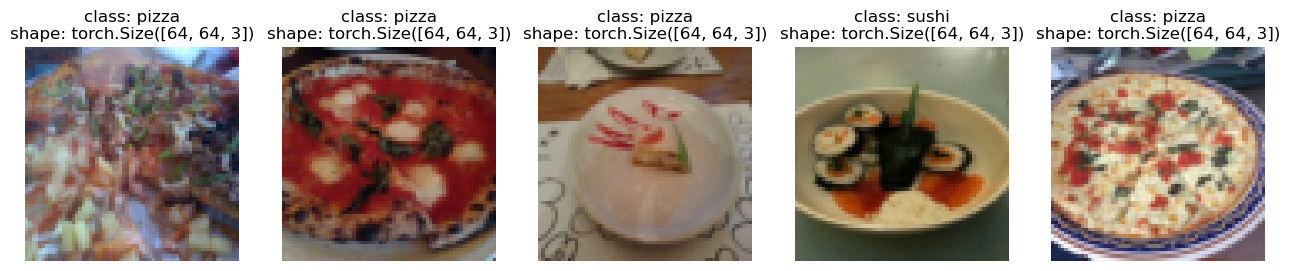

In [33]:
# 显示从 ImageFolder 创建的 Dataset 中的随机图像
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

现在用我们自己创建的 `ImageFolderCustom` 数据集来测试一下

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


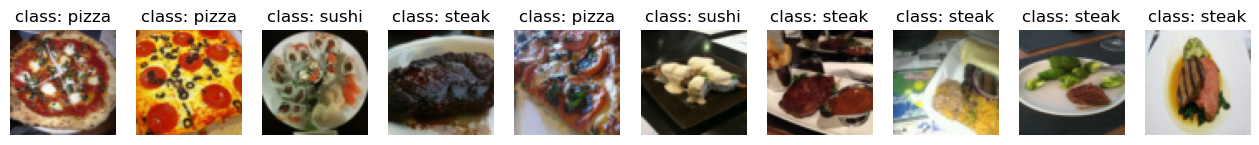

In [34]:
# 显示来自 ImageFolderCustom 数据集的随机图像
display_random_images(train_data_custom, 
                      n=12, 
                      classes=class_names,
                      seed=None)  # 尝试设置 seed 以获得可复现的图像

看起来我们的 `ImageFolderCustom` 按照预期正常工作。

### 5.4 将自定义加载的图像转化为 `DataLoader`

我们已经有了一种方法，通过我们的 `ImageFolderCustom` 类将原始图像转化为 `Dataset`（特征与标签的映射，或者说 `X` 映射到 `y`）。

那么，我们如何将我们自定义的 `Dataset` 转化为 `DataLoader` 呢？

如果你猜到是使用 `torch.utils.data.DataLoader()`，那么你猜对了！

因为我们的自定义 `Dataset` 类继承自 `torch.utils.data.Dataset`，我们可以直接将它们与 `torch.utils.data.DataLoader()` 一起使用。

我们可以采用与之前非常相似的步骤，只不过这次我们将使用我们自定义创建的 `Dataset`。

In [35]:
# 将自定义的训练和测试 Dataset 转换为 DataLoader
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,  # 使用自定义创建的训练 Dataset
                                     batch_size=1,  # 每个 batch 中的样本数量
                                     num_workers=0,  # 加载数据时使用多少子进程？（数值越大，计算资源越多）
                                     shuffle=True)  # 是否打乱数据？

test_dataloader_custom = DataLoader(dataset=test_data_custom,  # 使用自定义创建的测试 Dataset
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)  # 测试数据通常不需要打乱

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x178d4fb00>,
 <torch.utils.data.dataloader.DataLoader at 0x177f6c110>)

样本的形状看起来一样吗？

In [36]:
# 从自定义 DataLoader 获取图像和标签
img_custom, label_custom = next(iter(train_dataloader_custom))

# 批大小现在为 1，尝试更改上面的 batch_size 参数并查看会发生什么
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


它们确实是一样的！

现在让我们看看一些其他形式的数据转换。

## 6. 其他形式的变换（数据增强）

我们已经在数据上使用了一些变换，但还有很多其他的变换可供使用。

你可以在 [`torchvision.transforms` 文档](https://pytorch.org/vision/stable/transforms.html) 中查看所有变换。

变换的目的是以某种方式修改你的图像。

这可能是将图像转换为张量（如我们之前所做的）。

或者裁剪图像、随机擦除一部分、或随机旋转它们。

这种类型的变换通常被称为 **数据增强**。

**数据增强** 是通过某种方式修改数据，*人工* 增加训练集的多样性。

在这个 *人工* 修改的数据集上训练模型，期望能得到一个更具 *泛化能力* 的模型（它所学到的模式对未来未见的样本具有更强的适应性）。

你可以在 PyTorch 的 [变换示例插图](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#illustration-of-transforms) 中看到许多使用 `torchvision.transforms` 对图像进行的数据增强示例。

但我们不妨自己试试。

机器学习的核心就是利用随机性，而研究表明，随机变换（如 [`transforms.RandAugment()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randaugment) 和 [`transforms.TrivialAugmentWide()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)）通常比手动挑选的变换效果更好。

[TrivialAugment](https://arxiv.org/abs/2103.10158) 背后的理念……嗯，可以说是简单明了。

你有一组变换，随机选择其中一些，并以给定范围内的随机幅度应用它们（幅度越大，变换越强烈）。

PyTorch 团队甚至在 [训练他们最新的最先进视觉模型时使用了 TrivialAugment](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements)。

![TrivialAugment 在 PyTorch 最新模型训练中的数据增强应用](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-trivial-augment-being-using-in-PyTorch-resize.png)

*TrivialAugment 是最近提升 PyTorch 视觉模型训练精度的关键技术之一。*

我们来试试看，将它应用到我们自己的图像上怎么样？

在 `transforms.TrivialAugmentWide()` 中，主要需要关注的参数是 `num_magnitude_bins=31`。

它定义了选择一个强度值的范围，`0` 表示没有范围，而 `31` 表示最大范围（更高的范围意味着更强的强度）。

我们可以将 `transforms.TrivialAugmentWide()` 融入到 `transforms.Compose()` 中。

In [48]:
from torchvision import transforms

# 定义训练数据的预处理和增强操作
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 将图像调整为224x224的大小
    transforms.TrivialAugmentWide(num_magnitude_bins=31),  # 进行简单的广泛增强，num_magnitude_bins设置增强强度的类别数
    transforms.ToTensor()  # 使用ToTensor()将图像转化为张量并缩放到0和1之间
])

# 对测试数据不需要进行数据增强，只需要调整大小和转化为张量
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 将图像调整为224x224的大小
    transforms.ToTensor()  # 使用ToTensor()将图像转化为张量并缩放到0和1之间
])

**注意：** 通常情况下，你不会对测试集进行数据增强。数据增强的目的是*人为地*增加训练集的多样性，从而提高在测试集上的预测能力。

然而，你需要确保测试集中的图像被转换为张量。我们将测试图像调整为与训练图像相同的大小，但如果需要，推理也可以在不同大小的图像上进行（尽管这可能会影响性能）。

太好了，现在我们已经有了带有数据增强的训练集转换和不带数据增强的测试集转换。

现在，让我们来测试一下我们的数据增强效果！

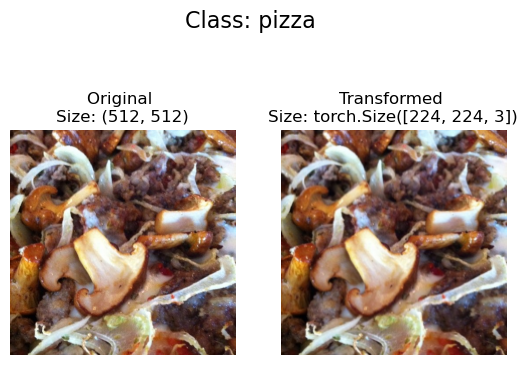

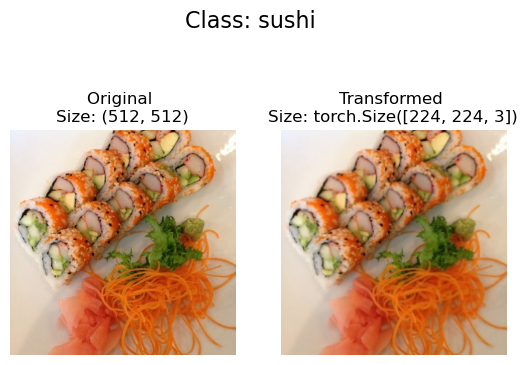

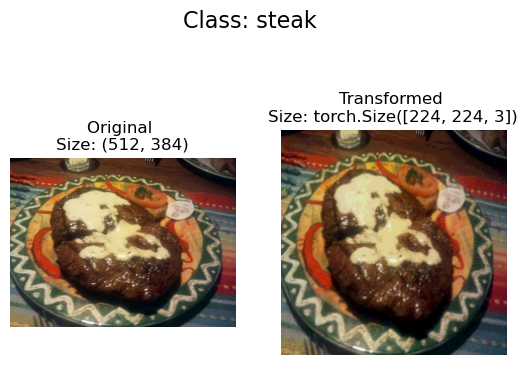

In [49]:
# 获取所有图像的路径
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 随机显示一些图像
plot_transformed_images(
    image_paths=image_path_list,  # 传入图像路径列表
    transform=train_transforms,  # 使用训练时的转换操作
    n=3,  # 显示3张随机图像
    seed=None  # 不设置随机种子（每次运行会不同）
)

尝试运行上面的代码单元几次，观察原始图像在经过转换后如何变化。

## 7. 模型 0：没有数据增强的 TinyVGG

好的，我们已经了解了如何将文件夹中的图像数据转换为经过处理的张量。

现在，让我们构建一个计算机视觉模型，看看是否能对图像进行分类，判断它是披萨、牛排还是寿司。

首先，我们从一个简单的转换开始，只将图像调整为 `(64, 64)` 的大小，并将它们转换为张量。

### 7.1 创建转换操作并加载 Model 0 的数据

In [50]:
# 创建简单的转换操作
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),  # 将图像调整为64x64的大小
    transforms.ToTensor(),  # 将图像转换为张量
])

现在我们有了一个简单的转换操作，接下来我们要做的是：

1. 加载数据，首先使用 `torchvision.datasets.ImageFolder()` 将每个训练集和测试集文件夹转化为一个 `Dataset`。
2. 然后使用 `torch.utils.data.DataLoader()` 将其转化为一个 `DataLoader`。
    * 我们将设置 `batch_size=32`，并将 `num_workers` 设置为机器上可用的 CPU 核心数（这取决于你使用的机器）。

In [52]:
# 1. 加载并转换数据
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)  # 加载训练数据并应用转换操作
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)  # 加载测试数据并应用转换操作

# 2. 将数据转化为 DataLoader
import os
from torch.utils.data import DataLoader

# 设置批处理大小和工作线程数
BATCH_SIZE = 32  # 每批次数据的大小
NUM_WORKERS = os.cpu_count()  # 获取机器的CPU核心数
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# 创建 DataLoader
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE,  # 设置批处理大小
                                     shuffle=True,  # 训练数据打乱
                                     num_workers=NUM_WORKERS)  # 设置工作线程数

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE,  # 设置批处理大小
                                    shuffle=False,  # 测试数据不打乱
                                    num_workers=NUM_WORKERS)  # 设置工作线程数

train_dataloader_simple, test_dataloader_simple  # 返回训练和测试的 DataLoader


Creating DataLoader's with batch size 32 and 8 workers.


(<torch.utils.data.dataloader.DataLoader at 0x178bfaff0>,
 <torch.utils.data.dataloader.DataLoader at 0x178f388f0>)

`DataLoader` 创建完成！

现在让我们构建一个模型。

### 7.2 创建 TinyVGG 模型类

在 [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/#7-model-2-building-a-convolutional-neural-network-cnn) 中，我们使用了来自 [CNN Explainer 网站](https://poloclub.github.io/cnn-explainer/) 的 TinyVGG 模型。

现在我们来重新创建这个模型，不过这次我们将使用彩色图像（RGB），而不是灰度图像（`in_channels=3` 替代 `in_channels=1`）。

In [53]:
class TinyVGG(nn.Module):
    """
    模型架构：复制自 TinyVGG，来源于:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,  # 输入通道数
                      out_channels=hidden_units,  # 输出通道数
                      kernel_size=3,  # 卷积核大小（这个卷积核覆盖图像的区域大小）
                      stride=1,  # 步幅（默认值）
                      padding=1),  # 填充（"valid"表示无填充，"same"表示输出和输入大小相同，或者指定具体的填充数）
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,  # 池化层的卷积核大小
                         stride=2)  # 步幅（默认值与卷积核大小相同）
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # in_features是怎么来的？
            # 因为网络的每一层都会压缩并改变输入数据的形状。
            nn.Linear(in_features=hidden_units*16*16,  # 输入特征的数量
                      out_features=output_shape)  # 输出特征的数量
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)  # 通过第一块卷积层
        # print(x.shape)
        x = self.conv_block_2(x)  # 通过第二块卷积层
        # print(x.shape)
        x = self.classifier(x)  # 通过分类器层
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x)))  # <- 利用操作符融合的优势

# 设置随机种子
torch.manual_seed(42)
# 创建模型实例
model_0 = TinyVGG(input_shape=3,  # 输入的颜色通道数（RGB为3）
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

> **注意：** 提升深度学习模型在 GPU 上计算速度的一种方法是利用 **操作符融合**。
>
> 这意味着在我们上面模型的 `forward()` 方法中，避免每次调用一个层块并重新赋值给 `x`，而是将每个层块顺序调用（见 `forward()` 方法最后一行的示例）。
>
> 这样可以节省重新赋值 `x`（内存开销大的操作）的时间，专注于只对 `x` 进行计算。
> 
> 更多关于如何加速机器学习模型的技巧，可以参考 Horace He 的文章 [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html)。

现在这个模型看起来不错！

我们来用一张图像进行前向传播测试一下吧？

### 7.3 对单张图像进行前向传播测试（测试模型）

测试模型的一个好方法是对单个数据进行前向传播。

这也是一个很好的方式来测试我们不同层的输入和输出形状。

要对单张图像进行前向传播测试，我们需要：

1. 从 `DataLoader` 获取一批图像和标签。
2. 从这一批数据中取出一张图像，并使用 `unsqueeze()` 操作将图像的批量大小调整为 `1`（使其形状适应模型）。
3. 对单张图像进行推理（确保将图像传送到目标 `device`）。
4. 打印出推理结果，并使用 `torch.softmax()` 将模型的原始输出 logits 转换为预测概率（因为我们正在处理多类数据），然后使用 `torch.argmax()` 将预测概率转换为预测标签。

In [54]:
# 1. 从 DataLoader 获取一批图像和标签
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. 从这一批中获取一张图像，并使用 unsqueeze() 将图像的形状调整为适应模型的大小
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. 对单张图像进行前向传播
model_0.eval() # 切换到评估模式
with torch.inference_mode(): # 进入推理模式
    pred = model_0(img_single.to(device)) # 将图像发送到目标设备并进行推理
     
# 4. 打印出发生的事情，并将模型的 logits -> 预测概率 -> 预测标签
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]])

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]])

Output prediction label:
tensor([1])

Actual label:
2


看起来我们的模型输出的结果正是我们预期的。

你可以多次运行上面的代码，每次都会预测不同的图像。

你可能会注意到，预测结果经常是错误的。

这是可以预期的，因为模型还没有训练，它实际上是在使用随机权重进行猜测。

### 7.4 使用 `torchinfo` 获取模型中数据形状的信息

通过 `print(model)` 打印模型，可以让我们了解模型的基本结构。

我们还可以打印出数据在 `forward()` 方法中的形状。

不过，一个更有帮助的方式是使用 [`torchinfo`](https://github.com/TylerYep/torchinfo) 来获取模型的详细信息。

`torchinfo` 提供了一个 `summary()` 方法，接收一个 PyTorch 模型和 `input_shape` 参数，并返回数据在模型中各层传递时的形状变化。

> **注意：** 如果你使用的是 Google Colab，你需要先安装 `torchinfo`。

In [55]:
# 如果 torchinfo 没有安装，则进行安装；如果已安装，则直接导入
try: 
    import torchinfo
except:
    !pip install torchinfo  # 安装 torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])  # 对一个示例输入大小进行测试传递

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

很好！

`torchinfo.summary()` 的输出提供了关于我们模型的很多信息。

比如 `Total params`，即模型中的总参数数量；`Estimated Total Size (MB)`，即模型的大小。

你还可以看到数据在通过模型时，输入和输出形状的变化。

目前，我们的参数数量和模型总大小都比较小。

这是因为我们从一个小模型开始。

如果以后需要增加模型的大小，我们是可以做到的。

### 7.5 创建训练与测试循环函数

我们已经有了数据和模型。

接下来，让我们创建一些训练和测试循环函数，用来在训练数据上训练模型，并在测试数据上评估模型。

为了确保以后可以重复使用这些训练和测试循环，我们将它们封装成函数。

具体来说，我们将创建三个函数：
1. `train_step()` - 接收模型、`DataLoader`、损失函数和优化器，并在 `DataLoader` 上训练模型。
2. `test_step()` - 接收模型、`DataLoader` 和损失函数，并在 `DataLoader` 上评估模型。
3. `train()` - 在指定的训练周期内执行步骤 1 和步骤 2，并返回一个结果字典。

> **注意：** 我们在 [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/#creating-an-optimization-loop-in-pytorch) 中详细讨论了 PyTorch 优化循环的步骤，以及 [Unofficial PyTorch Optimization Loop Song](https://youtu.be/Nutpusq_AFw)，并且我们在 [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/#62-functionizing-training-and-test-loops) 中构建了类似的函数。

现在，让我们从构建 `train_step()` 函数开始。

因为我们在 `DataLoader` 中处理的是批量数据，所以我们将在训练过程中累积每个批次的模型损失和准确率（通过将每个批次的结果加起来），然后在最后调整它们再返回。

In [56]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # 将模型设置为训练模式
    model.train()
    
    # 设置训练损失和训练准确率的初始值
    train_loss, train_acc = 0, 0
    
    # 遍历数据加载器中的数据批次
    for batch, (X, y) in enumerate(dataloader):
        # 将数据发送到目标设备
        X, y = X.to(device), y.to(device)

        # 1. 前向传播
        y_pred = model(X)

        # 2. 计算并累积损失
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. 优化器梯度清零
        optimizer.zero_grad()

        # 4. 反向传播
        loss.backward()

        # 5. 优化器更新参数
        optimizer.step()

        # 计算并累积准确率指标
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # 调整指标，获取每个批次的平均损失和准确率
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

`train_step()` 函数完成了。

现在让我们为 `test_step()` 函数做同样的事情。

主要的不同是，`test_step()` 不会接收优化器，因此不会执行梯度下降。

但是由于我们正在进行推理，我们需要确保在进行预测时启用 `torch.inference_mode()` 上下文管理器。

In [59]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # 将模型设置为评估模式
    model.eval() 
    
    # 设置测试损失和测试准确率的初始值
    test_loss, test_acc = 0, 0
    
    # 启用推理模式
    with torch.inference_mode():
        # 遍历 DataLoader 中的批次数据
        for batch, (X, y) in enumerate(dataloader):
            # 将数据发送到目标设备
            X, y = X.to(device), y.to(device)
    
            # 1. 前向传播
            test_pred_logits = model(X)

            # 2. 计算并累积损失
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # 计算并累积准确率
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # 调整指标，获取每个批次的平均损失和准确率
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 创建一个 `train()` 函数来结合 `train_step()` 和 `test_step()` 函数

现在我们需要一种方法将 `train_step()` 和 `test_step()` 函数结合起来。

为此，我们将把它们封装在一个 `train()` 函数中。

这个函数将用于训练和评估模型。

具体来说，它将执行以下操作：
1. 接收一个模型，一个用于训练和测试集的 `DataLoader`，一个优化器，一个损失函数，以及训练和测试步骤的迭代次数（epochs）。
2. 创建一个空的结果字典，用来存储 `train_loss`、`train_acc`、`test_loss` 和 `test_acc` 的值（随着训练的进行填充这些值）。
3. 循环执行训练和测试步骤函数，迭代指定的训练轮数（epochs）。
4. 在每个 epoch 结束时打印当前的进展。
5. 在每个 epoch 结束后，更新结果字典中的指标。
6. 返回已填充的结果字典。

为了跟踪我们已经经历了多少个 epoch，我们将从 `tqdm.auto` 导入 `tqdm`（[`tqdm`](https://github.com/tqdm/tqdm) 是 Python 中最流行的进度条库之一，`tqdm.auto` 会自动根据你的计算环境（如 Jupyter Notebook 或 Python 脚本）选择最合适的进度条类型）。

In [61]:
from tqdm.auto import tqdm

# 1. 接收训练和测试步骤所需的各种参数
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. 创建一个空的结果字典
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # 3. 循环执行训练和测试步骤，迭代指定的轮数
    for epoch in tqdm(range(epochs)):
        # 执行训练步骤
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        # 执行测试步骤
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        # 4. 打印出当前进展
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. 更新结果字典
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. 在所有 epoch 结束后返回填充好的结果
    return results

/opt/homebrew/Caskroom/miniconda/base/envs/MLenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 7.7 训练并评估模型 0

好了，所有的准备工作都已经完成，现在是时候将我们的 `TinyVGG` 模型、`DataLoader` 和 `train()` 函数结合起来，看看我们是否能构建出一个能够区分比萨饼、牛排和寿司的模型！

让我们重新创建 `model_0`（虽然我们不必这么做，但为了完整性，我们还是这样做），然后调用 `train()` 函数，传入所需的参数。

为了使实验更快捷，我们将训练模型 **5 个 epoch**（不过你可以根据需要增加这个值）。

关于 **优化器** 和 **损失函数**，我们将使用 `torch.nn.CrossEntropyLoss()`（因为我们处理的是多类分类数据）和 `torch.optim.Adam()`，学习率设为 `1e-3`。

为了计算训练时间，我们将导入 Python 的 [`timeit.default_timer()`](https://docs.python.org/3/library/timeit.html#timeit.default_timer) 方法来记录训练时间。

In [62]:
# 设置随机种子
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# 设置训练的 epoch 数量
NUM_EPOCHS = 5

# 重新创建 TinyVGG 实例
model_0 = TinyVGG(input_shape=3,  # 颜色通道数（RGB 为 3）
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# 设置损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# 启动计时器
from timeit import default_timer as timer 
start_time = timer()

# 训练 model_0
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# 结束计时并打印出训练所花费的时间
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [01:02<04:08, 62.00s/it]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604


 40%|████      | 2/5 [02:03<03:05, 61.67s/it]

Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979


 60%|██████    | 3/5 [03:04<02:02, 61.47s/it]

Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979


 80%|████████  | 4/5 [04:06<01:01, 61.47s/it]

Epoch: 4 | train_loss: 1.0992 | train_acc: 0.2891 | test_loss: 1.1338 | test_acc: 0.1979


100%|██████████| 5/5 [05:06<00:00, 61.39s/it]

Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1435 | test_acc: 0.1979
Total training time: 306.939 seconds


嗯...

看起来我们的模型表现得相当差。

但这没关系，我们会继续努力。

你觉得有哪些方法可以潜在地改善它呢？

> **备注：** 可以参考[《改进模型（从模型角度）》](https://www.learnpytorch.io/02_pytorch_classification/#5-improving-a-model-from-a-model-perspective)部分，获取一些改进我们 TinyVGG 模型的思路。

### 7.8 绘制模型 0 的损失曲线

从我们 `model_0` 的训练打印输出来看，模型的表现似乎不太好。

但是我们可以通过绘制模型的 **损失曲线** 来进一步评估它。

**损失曲线** 显示了模型在训练过程中的表现。

它们是观察模型在不同数据集（例如训练集和测试集）上表现的好方法。

接下来我们创建一个函数，用来绘制 `model_0_results` 字典中的数据。

In [63]:
# 检查 `model_0_results` 字典的键
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

我们需要提取每个键并将它们转换为图表。

In [66]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """绘制结果字典的训练曲线。

    参数:
        results (dict): 包含值列表的字典，例如：
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # 获取结果字典中的损失值（训练和测试）
    loss = results['train_loss']
    test_loss = results['test_loss']

    # 获取结果字典中的准确度值（训练和测试）
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # 确定训练的轮次
    epochs = range(len(results['train_loss']))

    # 设置绘图
    plt.figure(figsize=(15, 7))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # 绘制准确度曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();


好的，让我们测试一下我们的 `plot_loss_curves()` 函数。

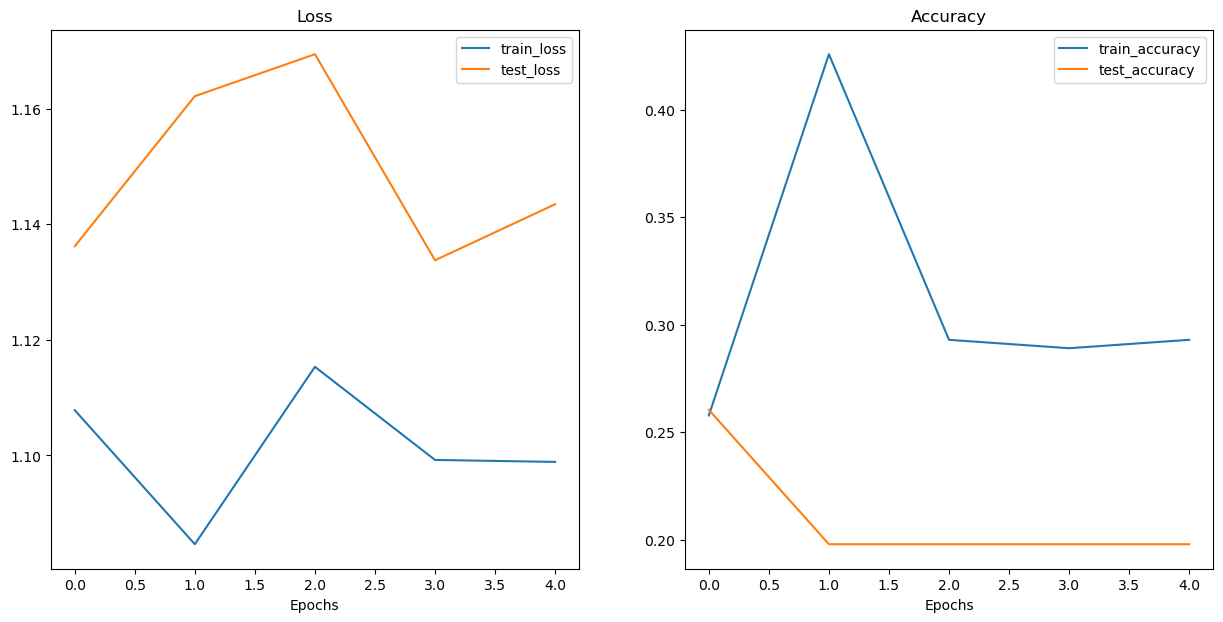

In [67]:
plot_loss_curves(model_0_results)

看起来结果有些乱七八糟……

不过我们也知道这可能会发生，因为我们模型在训练过程中输出的结果并没有显示出太多希望。

你可以尝试训练模型更长时间，然后看看当你在更长的时间跨度上绘制损失曲线时会发生什么。

## 8. 理想的损失曲线应该是什么样的？

查看训练和测试损失曲线是判断模型是否出现 **过拟合** 的好方法。

一个过拟合的模型是在训练集上的表现远好于验证集/测试集（通常差距较大）。

如果你的训练损失远低于测试损失，那说明你的模型正在 **过拟合**。

换句话说，它在训练数据中学得太好，但这些模式并没有很好地推广到测试数据上。

另一种情况是，当你的训练和测试损失都没有达到理想的低值时，这被认为是 **欠拟合**。

理想的情况是训练损失和测试损失曲线应该非常接近。

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="不同的训练和测试损失曲线，说明过拟合、欠拟合和理想的损失曲线" width="800"/>

*左：* 如果训练和测试损失曲线没有达到理想的低值，这被认为是 **欠拟合**。  
*中间：* 当测试/验证损失高于训练损失时，这被认为是 **过拟合**。  
*右：* 理想的情况是训练和测试损失曲线随时间对齐。这意味着模型的泛化能力很好。损失曲线有更多的组合方式，如果你想了解更多内容，可以参考谷歌的[解释损失曲线指南](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic)。

### 8.1 如何应对过拟合

由于过拟合的主要问题是模型对训练数据 **过度拟合**，因此你需要使用一些技巧来“限制”它。

一种常见的防止过拟合的技巧叫做[**正则化**](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html)。

我喜欢将其理解为“让我们的模型变得更加规律”，也就是说，让模型能够适应更多种类的数据。

下面我们讨论一些防止过拟合的方法。

| **防止过拟合的方法** | **它是什么？** |
| ----- | ----- |
| **获取更多数据** | 更多的数据可以给模型提供更多的机会去学习模式，这些模式可能更加能够推广到新的例子上。 |
| **简化模型** | 如果当前的模型已经过拟合了训练数据，它可能是一个过于复杂的模型。这意味着它学到了数据中的模式过于精细，无法很好地推广到未见过的数据。简化模型的一种方法是减少它使用的层数或减少每层的隐藏单元数量。 |
| **使用数据增强** | [**数据增强**](https://developers.google.com/machine-learning/glossary#data-augmentation)以某种方式操作训练数据，使得模型更难学习，同时人为地为数据增加更多的变化。如果模型能够在增强的数据上学习到模式，那么它可能能够更好地推广到未见过的数据上。 |
| **使用迁移学习** | [**迁移学习**](https://developers.google.com/machine-learning/glossary#transfer-learning)是指利用一个模型已经学习到的模式（也称为预训练权重）作为基础，应用到你自己的任务上。在我们的例子中，我们可以使用一个在大量图像上预训练的计算机视觉模型，然后稍微调整它，使其更专门化为食物图像。 |
| **使用 dropout 层** | Dropout 层在神经网络的隐藏层之间随机删除连接，有效地简化了模型，同时使剩余的连接变得更好。更多内容参见 [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)。 |
| **使用学习率衰减** | 这里的想法是随着模型训练的进行，逐渐减小学习率。这类似于伸手去拿沙发后面的硬币，当你越来越接近时，你的步伐也会变得越来越小。学习率也是如此，越接近[**收敛**](https://developers.google.com/machine-learning/glossary#convergence)，你希望权重更新的步伐越小。 |
| **使用早停法** | [**早停法**](https://developers.google.com/machine-learning/glossary#early_stopping)在模型开始过拟合之前停止训练。比如，如果模型的损失在过去 10 个周期内没有减少（这个数字是任意的），你可能希望停止训练，并选择在此之前损失最小的模型权重。 |

处理过拟合的方法还有很多，但这些是一些主要的方法。

随着你开始构建越来越深的模型，你会发现，由于深度学习在学习数据模式方面 **非常擅长**，因此应对过拟合是深度学习中的一个主要问题。

### 8.2 如何应对欠拟合

当模型出现[**欠拟合**](https://developers.google.com/machine-learning/glossary#underfitting)时，意味着它在训练集和测试集上都表现出较差的预测能力。

本质上，欠拟合的模型无法将损失值降低到理想的水平。

目前，观察我们的损失曲线，我认为我们的 `TinyVGG` 模型 `model_0` 存在欠拟合问题。

应对欠拟合的主要思路是 *增加* 模型的预测能力。

以下是几种可以解决欠拟合的方法：

| **防止欠拟合的方法** | **它是什么？** |
| ----- | ----- |
| **向模型添加更多层/单元** | 如果模型出现欠拟合，可能是因为它没有足够的能力去学习数据中的必要模式/权重/表示。向模型添加更多的预测能力的一种方法是增加隐藏层的数量，或者增加每层中的单元数量。 |
| **调整学习率** | 也许你的模型一开始的学习率设置得太高了，导致它在每个周期更新权重过多，从而无法有效学习。在这种情况下，你可以尝试降低学习率，看看效果如何。 |
| **使用迁移学习** | 迁移学习既能防止过拟合，也能解决欠拟合。它涉及使用先前训练过的模型中的模式，并将其调整以适应你自己的问题。 |
| **训练更长时间** | 有时候模型只是需要更多的时间来学习数据的表示。如果你发现模型在小规模实验中没有学习到任何东西，可能需要让它训练更多的轮次，看看是否能提高性能。 |
| **减少正则化** | 也许模型欠拟合是因为你过度使用了正则化技术。减少正则化可以帮助模型更好地拟合数据。 |

### 8.3 过拟合与欠拟合之间的平衡

上面讨论的这些方法并不是万灵药，这意味着它们并不总是有效。

防止过拟合和欠拟合可能是机器学习研究中最活跃的领域之一。

因为每个人都希望他们的模型能够更好地拟合数据（减少欠拟合），但又不希望它们过于拟合，以至于无法很好地泛化并在实际应用中表现良好（减少过拟合）。

过拟合和欠拟合之间有一条微妙的界限。

因为过多的任何一种都会导致另一种问题。

迁移学习可能是应对过拟合和欠拟合问题时最强大的技术之一。

与其手工制作不同的过拟合和欠拟合技术，迁移学习使你能够借用一个已经在类似问题空间中有效的模型（比如来自 [paperswithcode.com/sota](https://paperswithcode.com/sota) 或 [Hugging Face 模型](https://huggingface.co/models)）并将其应用于你自己的数据集。

我们将在后续的笔记中看到迁移学习的强大之处。

## 9. 模型 1：带数据增强的 TinyVGG

是时候尝试另一个模型了！

这一次，让我们加载数据并使用 **数据增强**，看看它是否能以某种方式改善我们的结果。

首先，我们将创建一个训练转换，包含 `transforms.TrivialAugmentWide()`，并对图像进行缩放和转换为张量。

对于测试转换，我们将做相同的操作，只是不使用数据增强。 

### 9.1 创建带数据增强的转换

In [68]:
# 创建带 TrivialAugment 的训练转换
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),  # 调整图像大小为 64x64
    transforms.TrivialAugmentWide(num_magnitude_bins=31),  # 使用 TrivialAugmentWide 进行数据增强
    transforms.ToTensor()  # 转换为张量
])

# 创建测试转换（不使用数据增强）
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 调整图像大小为 64x64
    transforms.ToTensor()  # 转换为张量
])

太棒了！

现在，让我们使用 `torchvision.datasets.ImageFolder()` 将图像转换为 `Dataset`，然后使用 `torch.utils.data.DataLoader()` 将其转换为 `DataLoader`。

### 9.2 创建训练和测试的 `Dataset` 和 `DataLoader`

我们将确保训练集的 `Dataset` 使用 `train_transform_trivial_augment`，而测试集的 `Dataset` 使用 `test_transform`。

In [69]:
# 将图像文件夹转换为 Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)  # 训练数据集，应用数据增强转换
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)  # 测试数据集，应用简单转换（无数据增强）

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

我们将创建 `DataLoader`，设置 `batch_size=32`，并将 `num_workers` 设置为我们机器上可用的 CPU 数量（我们可以使用 Python 的 `os.cpu_count()` 来获取这个值）。

In [70]:
# 将 Datasets 转换为 DataLoader's
import os
BATCH_SIZE = 32  # 设置批次大小为 32
NUM_WORKERS = os.cpu_count()  # 获取可用 CPU 数量

torch.manual_seed(42)  # 设置随机种子以确保结果可重复
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE,  # 设置批次大小
                                        shuffle=True,  # 训练集需要打乱顺序
                                        num_workers=NUM_WORKERS)  # 设置工作线程数

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE,  # 设置批次大小
                                    shuffle=False,  # 测试集不需要打乱顺序
                                    num_workers=NUM_WORKERS)  # 设置工作线程数

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x178f68980>,
 <torch.utils.data.dataloader.DataLoader at 0x178fd1730>)

### 9.3 构建并训练模型 1

数据加载完毕！

现在，来构建我们的下一个模型 `model_1`，我们可以重用之前的 `TinyVGG` 类。

我们会确保将其发送到目标设备上。

In [71]:
# 创建 model_1 并将其发送到目标设备
torch.manual_seed(42)  # 设置随机种子以确保结果可重复
model_1 = TinyVGG(
    input_shape=3,  # 输入形状为 3（RGB 图像）
    hidden_units=10,  # 隐藏层单元数为 10
    output_shape=len(train_data_augmented.classes)  # 输出形状为训练集类别数量
).to(device)  # 将模型发送到目标设备（如 GPU）
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

模型准备好了！

现在开始训练！

由于我们已经有了训练循环的函数（`train_step()`）、测试循环的函数（`test_step()`）以及将它们组合起来的 `train()` 函数，接下来我们将重用这些函数。

我们将使用与 `model_0` 相同的设置，唯一不同的是 `train_dataloader` 参数：
* 训练 5 个周期（epochs）。
* 在 `train()` 中使用 `train_dataloader=train_dataloader_augmented` 作为训练数据。
* 使用 `torch.nn.CrossEntropyLoss()` 作为损失函数（因为我们处理的是多分类问题）。
* 使用 `torch.optim.Adam()` 优化器，并设置学习率 `lr=0.001`。

In [72]:
# 设置随机种子
torch.manual_seed(42)  # 设置 CPU 随机种子
torch.cuda.manual_seed(42)  # 设置 GPU 随机种子

# 设置训练周期数
NUM_EPOCHS = 5  # 训练 5 个周期

# 设置损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 使用交叉熵损失函数（适用于多分类问题）
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)  # 使用 Adam 优化器，学习率为 0.001

# 启动计时器
from timeit import default_timer as timer
start_time = timer()  # 记录开始时间

# 训练 model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,  # 训练数据
                        test_dataloader=test_dataloader_simple,  # 测试数据
                        optimizer=optimizer,  # 优化器
                        loss_fn=loss_fn,  # 损失函数
                        epochs=NUM_EPOCHS)  # 训练周期数

# 结束计时器并输出训练时间
end_time = timer()  # 记录结束时间
print(f"Total training time: {end_time-start_time:.3f} seconds")  # 输出总训练时间

 20%|██        | 1/5 [01:01<04:06, 61.54s/it]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1059 | test_acc: 0.2604


 40%|████      | 2/5 [02:03<03:05, 61.88s/it]

Epoch: 2 | train_loss: 1.0790 | train_acc: 0.4258 | test_loss: 1.1385 | test_acc: 0.2604


 60%|██████    | 3/5 [03:05<02:03, 61.92s/it]

Epoch: 3 | train_loss: 1.0802 | train_acc: 0.4258 | test_loss: 1.1695 | test_acc: 0.2604


 80%|████████  | 4/5 [04:07<01:01, 61.93s/it]

Epoch: 4 | train_loss: 1.1286 | train_acc: 0.3047 | test_loss: 1.1621 | test_acc: 0.2604


100%|██████████| 5/5 [05:09<00:00, 61.82s/it]

Epoch: 5 | train_loss: 1.0885 | train_acc: 0.4258 | test_loss: 1.1478 | test_acc: 0.2604
Total training time: 309.089 seconds


嗯...

看起来我们的模型表现得并不好。

让我们查看一下它的损失曲线。

### 9.4 绘制模型 1 的损失曲线

由于我们已经将 `model_1` 的结果保存在一个名为 `model_1_results` 的字典中，我们可以使用 `plot_loss_curves()` 来绘制这些曲线。

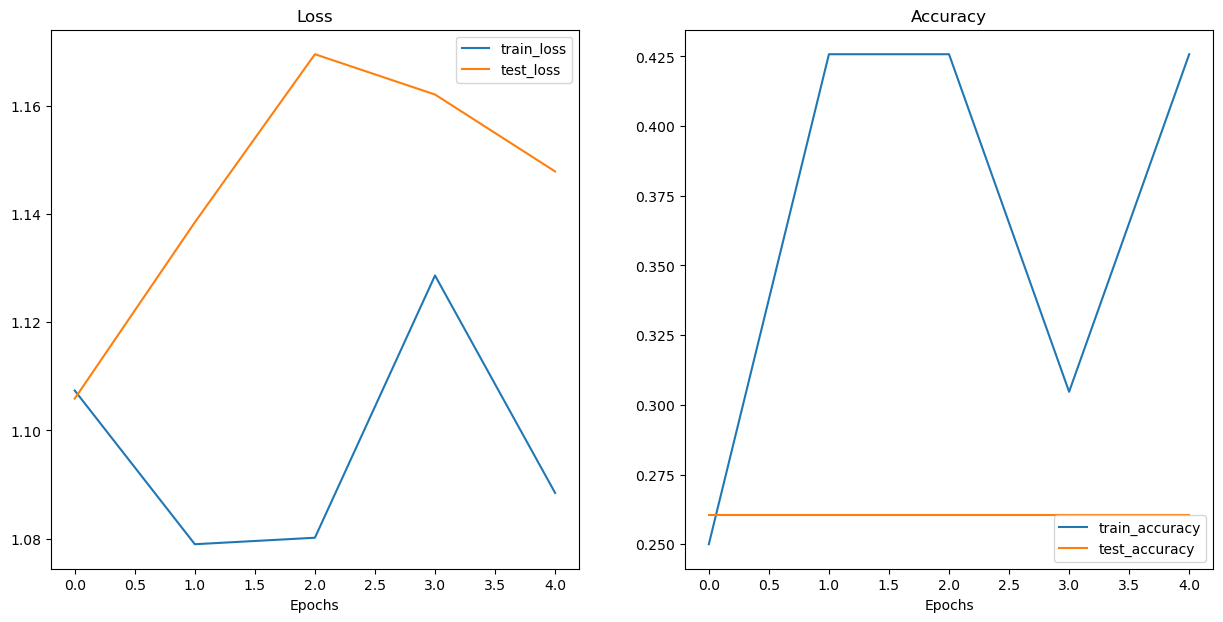

In [74]:
plot_loss_curves(model_1_results)

哇...

这些看起来也不太好...

我们的模型是 **欠拟合** 还是 **过拟合**？

还是两者都有？

理想情况下，我们希望模型能够有更高的准确度和更低的损失，对吧？

你可以尝试哪些方法来达到这些目标？

## 10. 比较模型结果

尽管我们的模型表现得很差，但我们仍然可以编写代码来比较它们。

首先，我们将模型的结果转换为 pandas DataFrame。

In [76]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107837,0.257812,1.136215,0.260417
1,1.084632,0.425781,1.162196,0.197917
2,1.115344,0.292969,1.169456,0.197917
3,1.099221,0.289062,1.133786,0.197917
4,1.098882,0.292969,1.143488,0.197917


现在我们可以使用 `matplotlib` 编写一些绘图代码，将 `model_0` 和 `model_1` 的结果一起可视化。

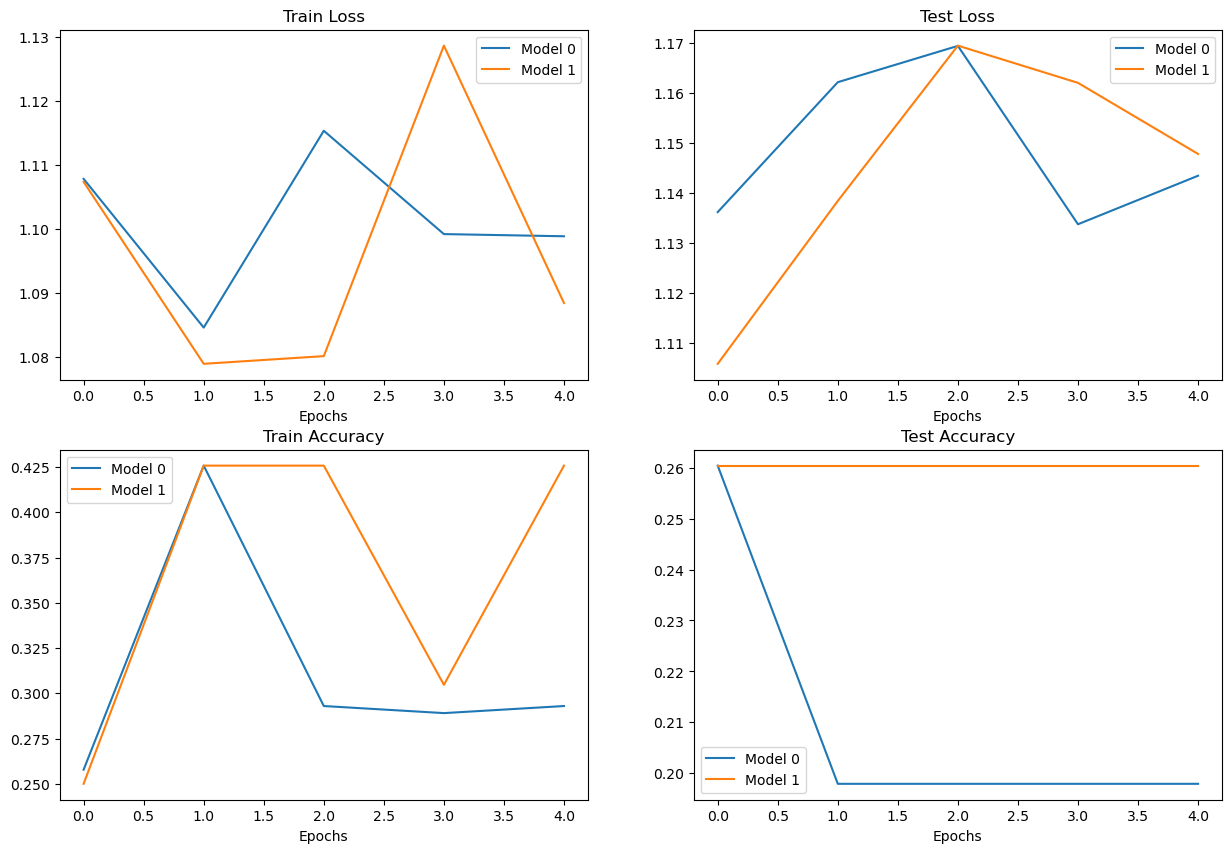

In [77]:
# 设置图表
plt.figure(figsize=(15, 10))

# 获取训练周期数
epochs = range(len(model_0_df))

# 绘制训练损失
plt.subplot(2, 2, 1)  # 设置为 2 行 2 列的第 1 个子图
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")  # 绘制模型 0 的训练损失
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")  # 绘制模型 1 的训练损失
plt.title("Train Loss")  # 设置标题
plt.xlabel("Epochs")  # 设置 x 轴标签
plt.legend()  # 显示图例

# 绘制测试损失
plt.subplot(2, 2, 2)  # 设置为 2 行 2 列的第 2 个子图
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")  # 绘制模型 0 的测试损失
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")  # 绘制模型 1 的测试损失
plt.title("Test Loss")  # 设置标题
plt.xlabel("Epochs")  # 设置 x 轴标签
plt.legend()  # 显示图例

# 绘制训练准确度
plt.subplot(2, 2, 3)  # 设置为 2 行 2 列的第 3 个子图
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")  # 绘制模型 0 的训练准确度
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")  # 绘制模型 1 的训练准确度
plt.title("Train Accuracy")  # 设置标题
plt.xlabel("Epochs")  # 设置 x 轴标签
plt.legend()  # 显示图例

# 绘制测试准确度
plt.subplot(2, 2, 4)  # 设置为 2 行 2 列的第 4 个子图
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")  # 绘制模型 0 的测试准确度
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")  # 绘制模型 1 的测试准确度
plt.title("Test Accuracy")  # 设置标题
plt.xlabel("Epochs")  # 设置 x 轴标签
plt.legend()  # 显示图例

看起来我们的两个模型表现都同样差，而且有点不稳定（指标波动较大）。

如果你构建了 `model_2`，你会做什么不同的调整来尝试提高性能呢？

## 11. 在自定义图像上进行预测

如果你已经在某个数据集上训练了模型，可能希望用它对你自己的自定义数据进行预测。

在我们的例子中，由于我们已经训练了一个识别披萨、牛排和寿司图像的模型，如何使用这个模型对我们自己的图像进行预测呢？

为此，我们需要加载一张图像，然后 **按与模型训练时相同的方式预处理它**。

换句话说，我们必须将自己的自定义图像转换为张量，并确保它的类型与模型训练时的数据类型匹配，才能将其传递给模型。

首先，我们从 GitHub 上下载一张自定义图像。

由于我们的模型是用来预测图像中是否包含披萨、牛排或寿司的，我们可以从 [Learn PyTorch for Deep Learning GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg) 下载一张“我的爸爸在给大披萨竖大拇指”的照片。

我们使用 Python 的 `requests` 模块下载这张图片。

> **注意：** 如果你使用的是 Google Colab，也可以通过左侧菜单 -> 文件 -> 上传到会话存储，上传图像。不过需要注意的是，当 Google Colab 会话结束时，这些图像会被删除。

In [78]:
# 下载自定义图像
import requests

# 设置自定义图像路径
custom_image_path = data_path / "04-pizza-dad.jpeg"

# 如果图像不存在，则下载
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # 从 GitHub 下载时，需要使用 "raw" 文件链接
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


### 11.1 使用 PyTorch 加载自定义图像

太棒了！

看起来我们已经成功下载了自定义图像并准备好使用，路径是 `data/04-pizza-dad.jpeg`。

接下来是加载图像。

PyTorch 的 `torchvision` 提供了多个用于读取和写入图像与视频的输入输出（简称 "IO"）方法，具体见 [`torchvision.io`](https://pytorch.org/vision/stable/io.html)。

由于我们需要加载图像，可以使用 [`torchvision.io.read_image()`](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image)。

这个方法可以读取 JPEG 或 PNG 格式的图像，并将其转化为一个三维的 RGB 或灰度 `torch.Tensor`，数据类型为 `uint8`，值的范围是 `[0, 255]`。

我们来试试看吧。

In [79]:
import torchvision

# 读取自定义图像
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# 打印图像数据
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

很好！看起来我们的图像已经是张量格式了，但是这个图像格式是否与我们的模型兼容呢？

我们的 `custom_image` 张量的数据类型是 `torch.uint8`，其值范围在 `[0, 255]` 之间。

但是我们的模型需要的数据格式是 `torch.float32`，并且值范围在 `[0, 1]` 之间。

因此，在将自定义图像输入到模型之前，我们**需要将其转换为与模型训练数据相同的格式**。

如果不这样做，我们的模型将会出错。

In [80]:
# 尝试对 `uint8` 格式的图像进行预测（这将会报错）
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

如果我们尝试对数据类型与模型训练时不同的图像进行预测，就会出现类似下面的错误：

> `RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same`

我们可以通过将自定义图像转换为与模型训练时相同的数据类型（`torch.float32`）来修复这个问题。

In [81]:
# 读取自定义图像并将张量值转换为 float32 类型
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# 将图像像素值除以 255，使其范围在 [0, 1] 之间
custom_image = custom_image / 255.

# 打印图像数据
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

### 11.2 使用训练好的 PyTorch 模型对自定义图像进行预测

太好了，看起来我们的图像数据现在与模型训练时的数据格式一致了。

但还有一个问题……

那就是它的 `shape`（形状）。

我们的模型是在形状为 `[3, 64, 64]` 的图像上训练的，而我们的自定义图像当前是 `[3, 4032, 3024]`。

我们该如何确保自定义图像的形状与模型训练时的图像相同呢？

有没有 `torchvision.transforms` 可以帮助我们呢？

在回答这个问题之前，我们先使用 `matplotlib` 绘制图像，确保它看起来正常。记得，我们需要将维度从 `CHW` 转换为 `HWC`，以符合 `matplotlib` 的要求。

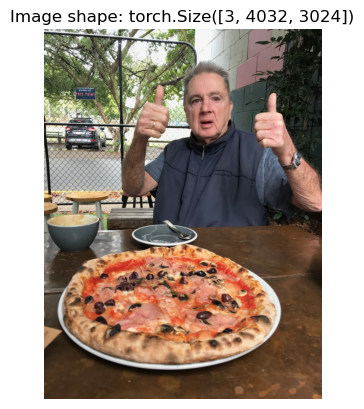

In [82]:
# 绘制自定义图像
plt.imshow(custom_image.permute(1, 2, 0))  # 需要将图像的维度从 CHW 转换为 HWC，否则 matplotlib 会报错
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);  # 隐藏坐标轴

两个大拇指！

现在，我们如何将图像调整为与我们的模型训练时使用的图像大小相同呢？

一种方法是使用 `torchvision.transforms.Resize()`。

让我们编写一个转换管道来实现这一点。

In [83]:
# 创建图像调整大小的转换管道
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# 转换目标图像
custom_image_transformed = custom_image_transform(custom_image)

# 打印原始形状和新形状
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


现在，让我们最终对我们自己的自定义图像进行预测吧。

In [84]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

尽管我们已经做了很多准备，但我们的自定义图像和模型仍然在不同的设备上。

我们遇到了以下错误：

> `RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)`

让我们通过将 `custom_image_transformed` 移动到目标设备来解决这个问题。

In [85]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

现在怎么办？

看起来我们遇到了形状错误。

这可能是什么原因呢？

我们已经将自定义图像的大小转换为与我们模型训练时使用的图像相同...

哦，等等...

我们忽略了一个维度。

那就是批量大小（batch size）。

我们的模型期望输入的图像张量在最前面有一个批量大小维度（`NCHW`，其中 `N` 是批量大小）。

但是我们自定义的图像目前只有 `CHW` 维度。

我们可以通过使用 `torch.unsqueeze(dim=0)` 为图像添加一个批量大小维度，从而*最终*进行预测。

本质上，我们将告诉模型对单张图像进行预测（即批量大小为 1 的图像）。

In [86]:
model_1.eval()
with torch.inference_mode():
    # 为图像添加额外的维度
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # 打印出不同的形状
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # 对添加了额外维度的图像进行预测
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


太好了！！！

看起来成功了！

> **注意：**我们刚刚经历的三个问题是深度学习和PyTorch中最常见的经典问题：
> 1. **数据类型错误** - 我们的模型期望的是`torch.float32`，而我们最初的自定义图像是`uint8`。
> 2. **设备错误** - 我们的模型在目标`device`上（在我们的例子中是GPU），而目标数据还没有移到目标`device`上。
> 3. **形状错误** - 我们的模型期望输入图像的形状为`[N, C, H, W]`或`[batch_size, color_channels, height, width]`，而我们的自定义图像张量的形状是`[color_channels, height, width]`。
>
> 请记住，这些错误不仅仅出现在自定义图像的预测中。
>
> 它们几乎会出现在你处理的每种数据类型（文本、音频、结构化数据）和问题中。

现在，让我们看看模型的预测结果。

In [87]:
custom_image_pred

tensor([[ 0.1188,  0.0273, -0.1461]])

好的，这些输出仍然是**logit形式**（模型的原始输出称为logits）。

我们现在将它们从logits转换为预测概率，再转换为预测标签。

In [88]:
# 打印预测的logits
print(f"Prediction logits: {custom_image_pred}")

# 将logits转换为预测概率（使用torch.softmax()进行多类分类）
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# 将预测概率转换为预测标签
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1188,  0.0273, -0.1461]])
Prediction probabilities: tensor([[0.3732, 0.3405, 0.2863]])
Prediction label: tensor([0])


好的！

看起来不错。

但是我们的预测标签仍然是索引/张量形式。

我们可以通过在 class_names 列表中索引来将其转换为字符串类名预测。

In [89]:
# 找到预测的标签
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]  # 将预测标签移至CPU，否则会报错
custom_image_pred_class

'pizza'

哇。

尽管根据我们的评估指标，模型表现不佳，但看起来它成功地做出了正确的预测。

> **注意：** 当前模型会根据输入的任何图像预测“披萨”、“牛排”或“寿司”。如果你希望模型预测其他类别，你需要训练它来执行这种任务。

但是，如果我们查看 `custom_image_pred_probs`，我们会注意到模型对每个类别的预测几乎给予相同的权重（值相似）。

In [90]:
# 预测概率的值非常相似
custom_image_pred_probs

tensor([[0.3732, 0.3405, 0.2863]])

预测概率如此相似可能意味着以下几种情况：
1. 模型正在尝试同时预测三个类（可能有一张包含披萨、牛排和寿司的图片）。
2. 模型并不清楚自己要预测什么，因此只是给每个类分配了相似的值。

我们的情况是第二种，因为我们的模型训练得不好，它实际上是在*猜测*预测结果。

### 11.3 将自定义图像预测整合在一起：构建一个函数

每次想要对自定义图像进行预测时，执行以上所有步骤会变得非常繁琐。

所以，让我们把这些步骤整合成一个可以轻松重复使用的函数。

具体来说，让我们构建一个函数，完成以下任务：
1. 接受目标图像路径，并将其转换为适合我们模型的正确数据类型（`torch.float32`）。
2. 确保目标图像的像素值在 `[0, 1]` 范围内。
3. 如果需要，对目标图像进行转换。
4. 确保模型在目标设备上。
5. 使用训练好的模型对目标图像进行预测（确保图像具有正确的尺寸并且与模型在同一设备上）。
6. 将模型输出的 logits 转换为预测概率。
7. 将预测概率转换为预测标签。
8. 将目标图像与模型的预测结果和预测概率一起绘制。

虽然步骤有点多，但我们一定能搞定！

In [91]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """对目标图像进行预测并绘制图像与预测结果。"""
    
    # 1. 加载图像并将张量值转换为 float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. 将图像像素值除以 255，使其范围变为 [0, 1]
    target_image = target_image / 255. 
    
    # 3. 如果需要，进行图像转换
    if transform:
        target_image = transform(target_image)
    
    # 4. 确保模型在目标设备上
    model.to(device)
    
    # 5. 开启模型评估模式和推理模式
    model.eval()
    with torch.inference_mode():
        # 为图像添加一个额外的维度
        target_image = target_image.unsqueeze(dim=0)
    
        # 在图像上进行预测，并将其发送到目标设备
        target_image_pred = model(target_image.to(device))
        
    # 6. 将 logits 转换为预测概率（使用 torch.softmax() 进行多类分类）
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. 将预测概率转换为预测标签
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. 绘制图像以及预测结果和预测概率
    plt.imshow(target_image.squeeze().permute(1, 2, 0))  # 确保图像大小符合 matplotlib 的要求
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

多么好看的函数，让我们试一下。

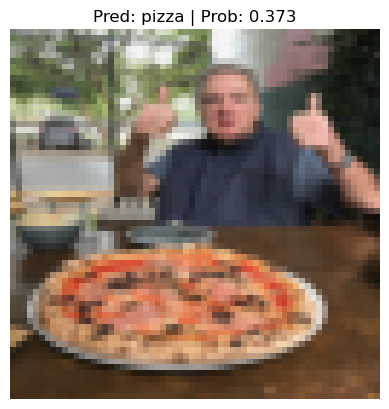

In [92]:
# 对我们的自定义图像进行预测
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

再次点赞！

看起来我们的模型仅凭猜测就得出了正确的预测。

不过，这种情况并不总是适用于其他图像...

由于我们使用 `custom_image_transform` 将图像大小调整为 `[64, 64]`，图像也变得像素化了。

> **练习：** 尝试使用你自己的披萨、牛排或寿司图片进行预测，看看会发生什么。

## 主要总结

我们在本模块中涵盖了很多内容。让我们用几个要点来总结一下。

* PyTorch 提供了许多内置函数，能够处理各种类型的数据，从图像到文本、音频以及推荐系统。
* 如果 PyTorch 内置的数据加载函数不符合你的需求，可以通过继承 `torch.utils.data.Dataset` 编写代码来创建自己的自定义数据集。
* PyTorch 中的 `torch.utils.data.DataLoader` 可以将你的 `Dataset` 转换为可迭代对象，用于训练和测试模型。
* 机器学习中有很多工作是关于**过拟合**和**欠拟合**之间的平衡（我们上面讨论了每种情况的不同方法，所以一个很好的练习是深入研究并编写代码尝试不同的技术）。
* 使用训练好的模型对你自己的自定义数据进行预测是可行的，只要你将数据格式化为与模型训练时相似的格式。确保你解决了三个常见的 PyTorch 和深度学习错误：
    1. **错误的数据类型** - 模型期望 `torch.float32`，而你的数据是 `torch.uint8`。
    2. **错误的数据形状** - 模型期望 `[batch_size, color_channels, height, width]`，而你的数据是 `[color_channels, height, width]`。
    3. **错误的设备** - 模型在 GPU 上，而你的数据在 CPU 上。

## 练习

所有练习都集中在练习上面部分的代码。

你可以通过参考每个部分或按照链接的资源完成这些练习。

所有练习应该使用[设备无关的代码](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code)来完成。

**资源：**
* [04 练习模板笔记本](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb)
* [04 练习示例解决方案笔记本](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/04_pytorch_custom_datasets_exercise_solutions.ipynb)（*在查看之前*，先尝试完成这些练习）

1. 我们的模型表现不佳（没有很好地拟合数据）。防止欠拟合的 3 种方法是什么？写下来并用一句话解释每种方法。
2. 重新创建我们在第 1、2、3 和 4 节中构建的数据加载函数。你应该准备好用于训练和测试的 `DataLoader`。
3. 重新创建我们在第 7 节中构建的 `model_0`。
4. 为 `model_0` 创建训练和测试函数。
5. 尝试训练你在练习 3 中构建的模型，训练 5、20 和 50 个 epoch，结果会怎样？
    * 使用 `torch.optim.Adam()` 作为优化器，学习率设置为 0.001。
6. 将模型中的隐藏单元数加倍，并训练 20 个 epoch，结果会怎样？
7. 将模型使用的数据量加倍，并训练 20 个 epoch，结果会怎样？
    * **注意：**你可以使用[自定义数据创建笔记本](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb)来扩展你的 Food101 数据集。
    * 你还可以在 GitHub 上找到[已经格式化好的双倍数据集（20% 而非 10% 子集）](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip)，你需要像练习 2 中那样编写下载代码，将其导入到这个笔记本中。
8. 对你自己的披萨、牛排或寿司自定义图片进行预测（你甚至可以从互联网上下载一张），并分享你的预测结果。
    * 你在练习 7 中训练的模型能正确预测吗？
    * 如果不能，你认为可以采取哪些措施来改进它？

## 额外课程

* 通过 PyTorch [datasets 和 dataloaders 教程笔记本](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)，来练习你对 PyTorch `Dataset` 和 `DataLoader` 的知识。
* 花 10 分钟阅读 [PyTorch `torchvision.transforms` 文档](https://pytorch.org/vision/stable/transforms.html)。
    * 你可以在[变换示例教程](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#illustration-of-transforms)中看到变换的实际演示。
* 花 10 分钟阅读 PyTorch [`torchvision.datasets` 文档](https://pytorch.org/vision/stable/datasets.html)。
    * 有哪些数据集给你留下了深刻的印象？
    * 你如何尝试在这些数据集上构建模型？
* [TorchData 当前处于测试版](https://pytorch.org/data/beta/index.html)（截至 2022 年 4 月），它将是 PyTorch 加载数据的未来方式，但你现在可以开始了解它。
* 为了加速深度学习模型，你可以做一些技巧来改善计算、内存和开销计算，更多内容可以阅读 Horace He 写的文章 [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html)。